# 3. Set up remote VM using AWS EC2

We will use AWS EC2 to set up a remote Linux virtual machine (VM) to train our model. 

hostname = aws-gpu.example.com

First we will check that we are correctly connected to the remote jupyter ipykernel in VS Code. Let us check some system information using bash commands.

https://code.visualstudio.com/docs/datascience/notebooks-web#:~:text=run%20your%20code.-,Connect%20to%20a%20remote%20Jupyter%20server,for%20your%20remote%20Jupyter%20server.

https://stackoverflow.com/questions/18705453/ssh-l-connection-successful-but-localhost-port-forwarding-not-working-channel

https://course20.fast.ai/start_aws

https://www.cyberciti.biz/faq/how-to-check-os-version-in-linux-command-line/

# 4. Train the U-Net segmentation model

Our goal is to train a U-Net model to segment building footprints from drone imagery. We will use [`fastai`](https://docs.fast.ai/) built on top of [`PyTorch`](https://pytorch.org/docs/stable/index.html) to train our model as our deep learning framework.

Using the [Data Block API](https://docs.fast.ai/data.block.html) we will create a [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) object that will contain our training and validation data. We will use the [`ImageDataBunch.from_folder`](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder) method to create our `DataBunch` object.

This section of the notebook is based on the [fastai Image Segmenation with CAMVID tutorial](https://docs.fast.ai/examples/camvid.html)


In [1]:
import matplotlib.pyplot as plt

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss, CrossEntropyLossFlat, DiceLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [2]:
# Check the Linux distribution, GPU model and CUDA version
!lsb_release -a
!nvidia-smi

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Sun Nov 26 14:06:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0              25W /  70W |      2MiB / 15360MiB |      6%      Default |
|                                         

In [3]:
# Check the installed packages
!mamba list

# packages in environment at /home/ubuntu/mambaforge/envs/geo:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
annotated-types           0.6.0                    pypi_0    pypi
anyio                     4.1.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h2372a71_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
babel                     2.13.1             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.2             pyha770c72_0    conda-forge

In [4]:
# Check that CUDA is available
torch.cuda.is_available()

True

In [5]:
TILE_SIZE = 256
ZOOM_LEVEL = 19

path = Path('./data')
for file in path.iterdir():
    print(file)

data/masks
data/images
data/polygons


In [6]:
# Get the path to the images and masks
path_images = path/'images'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'
path_masks = path/'masks'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'

# Get filenames for the training images and masks
file_names = get_image_files(path_images/'train')
label_names = get_image_files(path_masks/'train')

# Get filenames for the validation images and masks
file_names_validation = get_image_files(path_images/'validation')
label_names_validation = get_image_files(path_masks/'validation')

print('Training images:', len(file_names))
print('Training masks:', len(label_names))

Training images: 814
Training masks: 814


In [7]:
def get_image_mask(image_path: Path) -> Path:
    ''' Gets the path of the mask corresponding to the image path
    Args:
        image_path (Path): Path to the image

    Returns:
        Path: Path to the mask
    '''
    return path_masks/image_path.parent.name/f'{image_path.stem}_mask.png'

In [8]:
print('Example image: ', file_names[0])
print('Example mask: ', get_image_mask(file_names[0]))

Example image:  data/images/s256_z19/train/319381_270510_19.png
Example mask:  data/masks/s256_z19/train/319381_270510_19_mask.png


As the `PILMask.create` method opens the mask by default in `L` mode or grayscale and we want to open it in `RGB` mode. We will subclass `PILMask` directly with a new class `PILMaskRGB` and override the open method to open the mask in `RGB` mode.

<Axes: title={'center': 'Image with mask'}>

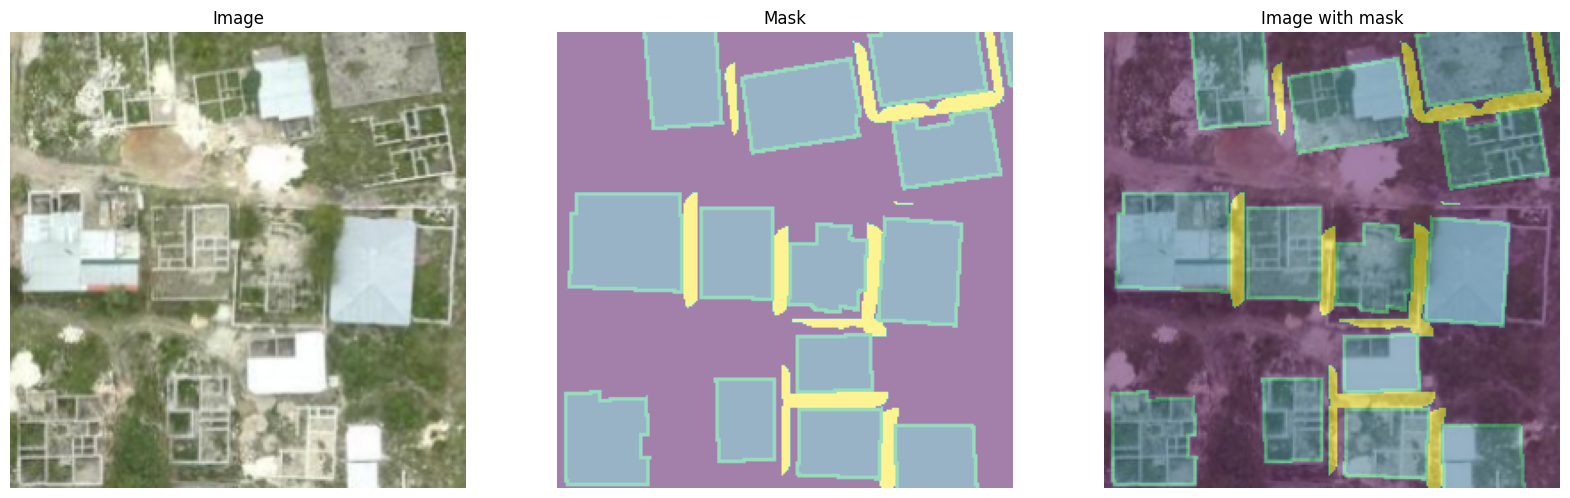

In [9]:
# Test opening an image and its mask
image_filename = file_names[15]
image = PILImage.create(image_filename)

mask = mask = PILMask.create(get_image_mask(image_filename))

# Show the image and mask side by side and overlay the mask on the image
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].set_title('Image')
image.show(ax=ax[0])

ax[1].set_title('Mask')
mask.show(ax=ax[1], cmap='viridis')

ax[2].set_title('Image with mask')
image.show(ax=ax[2])
mask.show(ax=ax[2], cmap='viridis', alpha=0.5)

In [17]:
# Classes for each channel in the mask
classes = ['Void', 'Footprint', 'Boundary', 'Contact']

# Turn this into a dictionary mapping from class to index
class_mapping = {'Void': 0, 'Footprint': 1, 'Boundary': 2, 'Contact': 3}
print(class_mapping)

{'Void': 0, 'Footprint': 1, 'Boundary': 2, 'Contact': 3}


In [18]:
# Define the image size and batch size
size = TILE_SIZE
batch_size = 16

# Define the data augmentation transforms to apply to the images and masks
batch_transforms = aug_transforms(flip_vert=True, max_warp=0.1, max_rotate=30, max_zoom=2, max_lighting=0.2)

# Define the data block
buildings = DataBlock(blocks=(ImageBlock, MaskBlock(codes=classes)),
                       get_items=get_image_files,
                       splitter=FuncSplitter(lambda o: o.parent.name == 'validation'),
                       get_y=get_image_mask,
                       batch_tfms=batch_transforms)

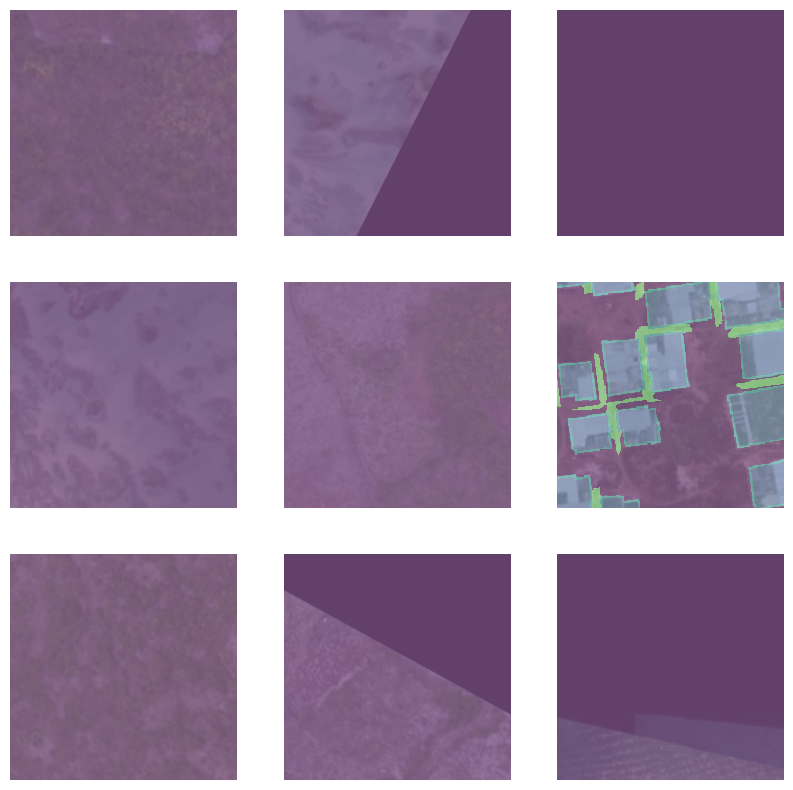

In [19]:
dataloders = buildings.dataloaders(path_images, bs=batch_size)

# Show a batch of images and masks
dataloders.show_batch(max_n=9, figsize=(10, 10), alpha=0.5, cmap='viridis')

In [20]:
# Make our vocabulary a part of the dataloaders, loss function needs to deal with the Void label
dataloders.vocab = classes

## Set up a Dynamic U-Net model
We will fastai's Dynamic U-Net model architecture to train our segmentation model. The U-Net model architecture was first introduced in the paper [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Olaf Ronneberger, Philipp Fischer, and Thomas Brox. The U-Net model architecture is a convolutional neural network (CNN) that was originally designed for biomedical image segmentation.

U-Net allows us to look at pixel-wise representations of our images through the use of a contracting path and an expansive path. The contracting path is a typical CNN that consists of convolutional and pooling layers. The expansive path is a series of up-convolutional layers that allow us to increase the resolution of the image. The expansive path is also known as the decoder and the contracting path is known as the encoder.

`unet_learner` from `fastai.vision.learner` is a factory method that creates a `Learner` object with a U-Net model architecture. We can pass in model configurations to the factory method where we can customise the model.
- `dls` is the `DataLoaders` object we created that contains our training and validation data
- `arch` is the U-Net model architecture we want to use, we will use resnet34 as the encoder
- `metrics` is the metric we want to use to evaluate our model, we will use the `Dice` metric
- `loss_func` is the loss function we want to use to train our model, will use the `Dice` loss function
- `opt_func` is the optimizer we want to use to train our model, we will use the state of the art `Ranger` optimiser
- `self_attention` is a boolean value that determines whether we want to use self-attention layers in our model, we will set it to `True`
- `act_cls` is the activation function we want to use in our model, we will use the `Mish` activation function

In [21]:
# Function to be used as the metric
def argmax_metric(input, target):
  target = target.squeeze(1)
  mask = target != class_mapping['Void']
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [27]:
# Define the model
learn = unet_learner(dls=dataloders, arch=resnet34, loss_func=DiceLoss(), opt_func=ranger, metrics=argmax_metric, self_attention=True, act_cls=Mish)

# Show the model summary
learn.summary()

DynamicUnet (Input shape: 16 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

SuggestedLRs(valley=0.0030199517495930195)

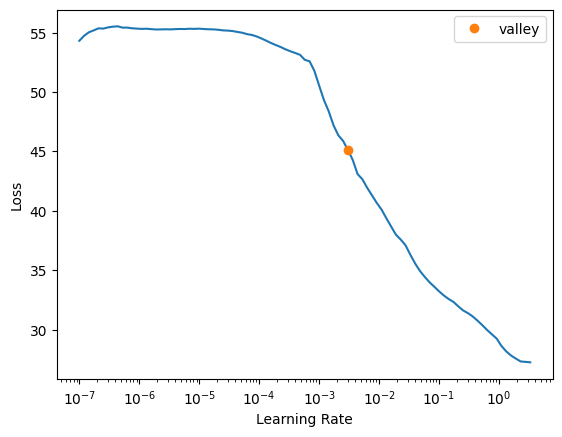

In [28]:
# Find the optimal learning rate
learn.lr_find()